In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
from math import sqrt
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
import time
from numpy import concatenate
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

In [2]:
# Load testing dataset(Daily data)
def read_daily_df(features,file):
    Lake_HydMet = pd.read_csv(file,header = 0,sep = '\t',parse_dates = ['Date'])
    Lake_HydMet = Lake_HydMet[features]
    return Lake_HydMet

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, var_name,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] # number of variables
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(var_name[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(var_name[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(var_name[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

In [4]:
# load dataset
def load_dataset(df,var_name):
    values = df[var_name].values
    return values

In [5]:
# reframe dataset
def reframe(values,hyperparameters,var_names):
    reframed = series_to_supervised(values, hyperparameters['time_steps'], hyperparameters['n_out'],var_names)
    reframed = reframed.iloc[hyperparameters['time_steps']:]
    drop_col =[]
    n_var = len(var_names)
    for i in range(1,hyperparameters['time_steps']+1):
        drop_col += [n_var*i-1]
    reframed.drop(reframed.iloc[:,drop_col],axis=1,inplace = True)
    return reframed

In [6]:
def sparse_dataset(data_X,data_y):
    index = []
    y = []
    for i in range(len(data_y)):
        if ~np.isnan(data_y[i]):
            index.append(i)
            y.append(data_y[i])
    X = np.stack(data_X[index,:,:])
    y = np.array(y)
    return index,X,y

In [7]:
def fit_lstm(train_X,train_y,n_batch,nb_epoch,n_neuros,dropout,verbose,loss_function):
    # design network
    model = Sequential()
    model.add(LSTM(n_neuros,  return_sequences = True,
              input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros, return_sequences = True))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss=loss_function, optimizer='adam')
    # fit network
    model.fit(train_X,train_y,epochs =nb_epoch,batch_size = n_batch,verbose = verbose)
    return model

In [8]:
def plot_comparison(df,y,yhat,yhat_ts,n_date,time_steps,index,rmse,r2,nutrient,test_time,ylim):
    # Observation time
    time = df['Date'].iloc[n_date+time_steps:].reset_index()['Date'].iloc[index] 
    # Direct comparison of observation and prediction [yhat] (data point to data point)
    pred = pd.DataFrame(concatenate((yhat.reshape(yhat.shape[0],1),y.reshape(y.shape[0],1)), axis=1),
                        index = time)
    pred.columns = ['Prediction','True value']
    # Extract the continuous timeseries from input dataset
    time_ts = df['Date'].iloc[n_date+time_steps:]
    # The continuous prediction yhat_ts 
    pred_ts = pd.DataFrame(yhat_ts,index = time_ts,columns = ['Prediction'])
    # Compute the 7d rolling mean of the timeseries predction
    pred_ts['Prediction_7d'] = pred_ts['Prediction'].rolling(7,min_periods = 1).mean()
    # Create a continous timeseries without winter gap
    Date = pd.DataFrame(pd.date_range(start = time_ts.iloc[0],
                                  end = time_ts.iloc[-1]),
                    columns = ['Date'])
    pred_ts_gap = Date.merge(pred_ts,how = 'left',on = 'Date')
    f1,ax1 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    pred_ts_gap.plot(x = 'Date',y = ['Prediction','Prediction_7d'],
                     style = {'Prediction':'b-','Prediction_7d':'k-'},
                     ax = ax1[0])
    pred.plot(y = 'True value',style='ro',alpha = 0.7,ms = 7,ax = ax1[0])
    ax1[0].set_ylabel(nutrient)
    ax1[0].set_xlim((test_time[0],test_time[1]))
    ax1[0].set_ylim(ylim)
    ax1[0].text(0.7, 0.9, 'RMSE:{}'.format(round(rmse,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax1[0].transAxes,fontsize='x-large')
    pred.plot(x = 'True value', y = 'Prediction',kind = 'scatter',s = 20,c = 'blue',ax = ax1[1])
    ax1[1].plot(pred['True value'],pred['True value'],lw  =1.5,color = 'black')
    ax1[1].text(0.5, 0.8, 'R2:{}'.format(round(r2,2)), 
                horizontalalignment='center',verticalalignment='center', 
                transform=ax1[1].transAxes,fontsize='x-large')
    return f1

In [9]:
def predict_ts(df,nutrient,model,hyperparameters,values):
    # add the predictive values into dataset
    value_X, value_y = values[:, :-1], values[:, -1]
    value_X = value_X.reshape((value_X.shape[0], hyperparameters['time_steps']+1, int(value_X.shape[1]/(hyperparameters['time_steps']+1))))
    y_pred = Scaler.inverse_transform(model.predict(value_X,batch_size = hyperparameters['n_batch']))    
    df[nutrient].iloc[hyperparameters['time_steps']:]=y_pred[:,0]
    df[nutrient].fillna(method = 'backfill',inplace = True)
    return df

In [10]:
def split_dataset(train,test,time_steps):
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], time_steps+1, int(train_X.shape[1]/(time_steps+1))))
    test_X = test_X.reshape((test_X.shape[0], time_steps+1, int(test_X.shape[1]/(time_steps+1))))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    print('number of input timesteps: {}'.format(train_X.shape[1]))
    print('number of features: {}'.format(train_X.shape[2]))
    return train_X, train_y,test_X, test_y

In [11]:
# ensure all data is float
def predict_lstm(df,values,var_name,nutrient,test_time,hyperparameters,ylim):
    n_date = df[df['Date']<test_time[0]]['Date'].count()
    train = values[:n_date, :]
    test = values[n_date:, :]
    train_X, train_y,test_X, test_y = split_dataset(train,test,hyperparameters['time_steps'])
    # fit the lstm model
    index,X,y = sparse_dataset(train_X,train_y) # stack the timeseries input together to create a 2D training input X, and a 1D lable y
    y_scaled = Scaler.fit_transform(y.reshape(-1,1))
    print('number of samples: {}'.format(len(index)))
    kf = KFold(n_splits=5, shuffle=True, random_state=101) # 5-fold cross validation
    RMSE = []
    R2 = []
    # fit the lstm model 
    for train_index, test_index in kf.split(X,y_scaled):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_scaled[train_index], y_scaled[test_index]
        model = fit_lstm(X_train,y_train,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                         hyperparameters['n_neuros'],hyperparameters['dropout'],
                         hyperparameters['verbose'],hyperparameters['loss_function'])
        yhat = Scaler.inverse_transform(model.predict(X_test,batch_size = hyperparameters['n_batch']))
        y_test = Scaler.inverse_transform(y_test)
        rmse = sqrt(mean_squared_error(y_test, yhat))
        r2 =  r2_score(y_test, yhat)
        RMSE.append(rmse) 
        R2.append(r2)
        #print('Training RMSE: %.2f' %rmse)       
    # make a prediction
    model = fit_lstm(X,y_scaled,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                     hyperparameters['n_neuros'],hyperparameters['dropout'],
                     hyperparameters['verbose'],hyperparameters['loss_function'])
    index,X,y = sparse_dataset(test_X,test_y) # index is the time series
    yhat = Scaler.inverse_transform(model.predict(X,batch_size = hyperparameters['n_batch']))
    rmse = sqrt(mean_squared_error(y, yhat))
    r2 = r2_score(y, yhat)
    print('Test RMSE: %.2f' % rmse)
    print('Test R2: %.2f' %r2)
    # make a prediction for the whole timeseries
    yhat_ts = Scaler.inverse_transform(model.predict(test_X,batch_size = hyperparameters['n_batch']))
    figure = plot_comparison(df,y,yhat,yhat_ts,n_date,hyperparameters['time_steps'],index,rmse,r2,nutrient,test_time,ylim)
    return model,RMSE,R2,figure

In [12]:
## Load training dataset
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
    
os.chdir('Trainning data')
print('Load training data (containing nutrient observations)')
lakename = input('Lake name in short:')
winter = input('Winter data or not? (Y/N)')
if winter =='Y':
    all_df = pd.read_csv(lakename+'_Observation_df.csv',sep = '\t',parse_dates = ['Date'])
else:
    all_df = pd.read_csv(lakename+'_Observation_df_nowinter.csv',sep = '\t',parse_dates = ['Date'])

Load training data (containing nutrient observations)
Lake name in short:Galten
Winter data or not? (Y/N)N


In [13]:
# Create the daily df with Nan in nutrients columns'
print(all_df.info())
n_Nut = int(input('Number of nutrients: (including Chl)'))
Nut_f = ['Date']
for i in range(n_Nut):
    f = input('Nutrients: ')
    Nut_f.append(f)
print(Nut_f)
Nut = all_df[Nut_f]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             131 non-null    datetime64[ns]
 1   Chl              122 non-null    float64       
 2   NH4-N            123 non-null    float64       
 3   NOX-N            98 non-null     float64       
 4   PO4-P            123 non-null    float64       
 5   Si               61 non-null     float64       
 6   Tot-P            123 non-null    float64       
 7   SST              69 non-null     float64       
 8   Tot-N            62 non-null     float64       
 9   thermD           131 non-null    float64       
 10  U                131 non-null    float64       
 11  AirT             131 non-null    float64       
 12  Prec             131 non-null    float64       
 13  RelHum           131 non-null    float64       
 14  swr              131 non-null    float64  

In [14]:
n_feature = int(input('Number of features used for basic training: '))
features = ['Date']
for i in range(n_feature):
    f = input('Feature:')
    features.append(f)
print(features)

Number of features used for basic training: 12
Feature:thermD
Feature:U
Feature:AirT
Feature:Prec
Feature:RelHum
Feature:swr
Feature:CC
Feature:MLD
Feature:W
Feature:delT
Feature:Ice_d
Feature:day_from_iceoff
['Date', 'thermD', 'U', 'AirT', 'Prec', 'RelHum', 'swr', 'CC', 'MLD', 'W', 'delT', 'Ice_d', 'day_from_iceoff']


In [15]:
# date to seperate training and test sets
YY=all_df['Date'].apply(lambda d:d.year).unique()
print(YY)
test_time = [pd.Timestamp(int(input('test starts in year:')),1,1),pd.Timestamp(int(input('test ends in year:')),1,1)]

[1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002]
test starts in year:1999
test ends in year:2003


In [16]:
# Read daily observation data
if winter =='Y':
    file = lakename+'_Daily_Observation_df.csv'
else:
    file = lakename+'_Daily_Observation_df_nowinter.csv'
Daily_df = read_daily_df(features,file) 

In [17]:
# set the hyperparameters
hyperparameters = {'n_batch':10,'nb_epoch':100,'n_neuros':100,'dropout':0.01,'time_steps':7,
                   'n_out':1,'verbose':0,
                  'loss_function':'mae'}

In [18]:
# Change to the LSTM folder
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
os.chdir('Scenario2\\LSTM')

Nutrient: NOX-N
(2475, 8, 12) (2475,) (1093, 8, 12) (1093,)
number of input timesteps: 8
number of features: 12
number of samples: 57
Test RMSE: 152.18
Test R2: -0.08
Training dataset RMSE 159.17 (+/- 56.04)
Training dataset R2 -0.14 (+/- 0.84)
Model takes 1 min to run


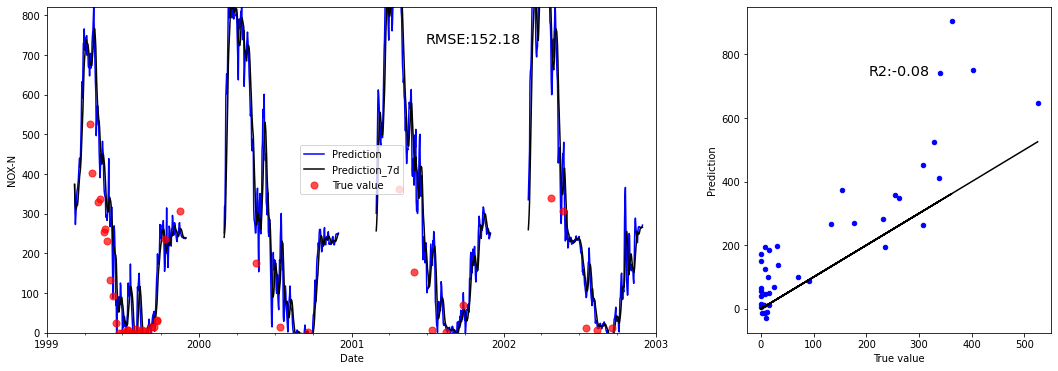

In [19]:
# predict nutreint 1
nutrient = input('Nutrient: ')
# If add the features from process-based model, add features 'MLD','W','thermD'
features.pop(0) # Remove 'Date'
features.append(nutrient)
Scaler = MinMaxScaler()
Nut_memory = Daily_df.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                            how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values
ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [20]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,U,AirT,Prec,RelHum,swr,CC,MLD,W,delT,Ice_d,day_from_iceoff,NOX-N
0,1990-03-01,-17.8,2.786438,-0.5350,0.09,87.250,51.505,0.79750,-18.0,0.002966,-0.008688,2.0,31.0,513.228516
1,1990-03-02,-17.8,7.849426,-0.6850,0.00,63.250,90.508,0.43250,-18.0,0.001339,-0.007953,2.0,32.0,513.228516
2,1990-03-03,-17.8,5.792219,-1.2975,0.03,56.125,93.743,0.40625,-18.0,0.000642,-0.007273,2.0,33.0,513.228516
3,1990-03-04,-17.8,5.742836,3.0775,5.24,84.875,52.951,0.75250,-18.0,0.000000,-0.003960,2.0,34.0,513.228516
4,1990-03-05,-17.8,12.217071,4.0650,0.83,68.750,62.892,0.70000,-18.0,0.000241,0.000475,2.0,35.0,513.228516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3570,2002-11-26,-17.8,3.396197,2.6775,9.75,98.750,8.086,0.97500,-18.0,0.001569,0.001628,81.0,266.0,263.020264
3571,2002-11-27,-17.8,4.465640,0.4650,0.25,96.875,25.670,0.59250,-18.0,0.001906,-0.000252,81.0,267.0,265.208527
3572,2002-11-28,-17.8,2.230251,-0.7850,0.30,97.250,8.143,0.91625,-18.0,0.008146,-0.003505,81.0,268.0,265.292114
3573,2002-11-29,-17.8,7.872476,-0.9725,0.63,89.000,6.721,0.99000,-18.0,0.000736,-0.000708,81.0,269.0,266.988586


Nutrient: PO4-P
['thermD', 'U', 'AirT', 'Prec', 'RelHum', 'swr', 'CC', 'MLD', 'W', 'delT', 'Ice_d', 'day_from_iceoff', 'NOX-N']
Delete features? (Y/N)N
Add features? (Y/N)N
(2475, 8, 13) (2475,) (1093, 8, 13) (1093,)
number of input timesteps: 8
number of features: 13
number of samples: 57
Test RMSE: 17.51
Test R2: -5.45
Training dataset RMSE 13.67 (+/- 9.72)
Training dataset R2 -2.90 (+/- 3.88)
Model takes 1 min to run


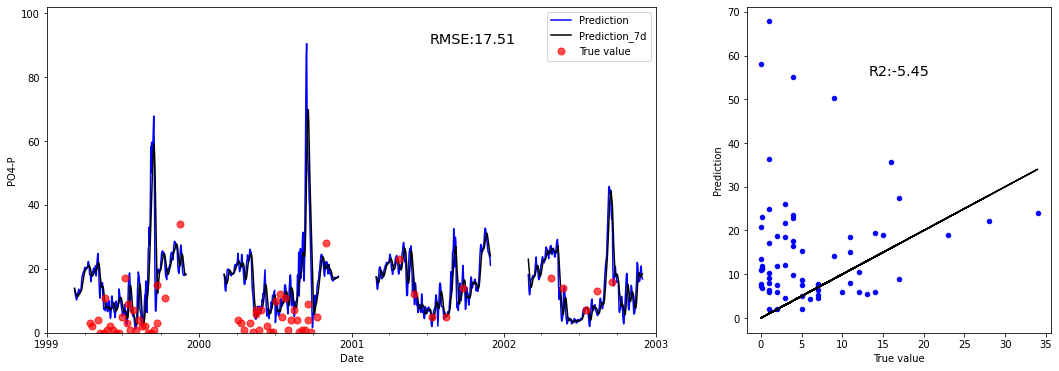

In [21]:
# predict nutreint 2
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 
    
Scaler = MinMaxScaler()
features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates()
                              ,how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [22]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,U,AirT,Prec,RelHum,swr,CC,MLD,W,delT,Ice_d,day_from_iceoff,NOX-N,PO4-P
0,1990-03-01,-17.8,2.786438,-0.5350,0.09,87.250,51.505,0.79750,-18.0,0.002966,-0.008688,2.0,31.0,513.228516,23.497503
1,1990-03-02,-17.8,7.849426,-0.6850,0.00,63.250,90.508,0.43250,-18.0,0.001339,-0.007953,2.0,32.0,513.228516,23.497503
2,1990-03-03,-17.8,5.792219,-1.2975,0.03,56.125,93.743,0.40625,-18.0,0.000642,-0.007273,2.0,33.0,513.228516,23.497503
3,1990-03-04,-17.8,5.742836,3.0775,5.24,84.875,52.951,0.75250,-18.0,0.000000,-0.003960,2.0,34.0,513.228516,23.497503
4,1990-03-05,-17.8,12.217071,4.0650,0.83,68.750,62.892,0.70000,-18.0,0.000241,0.000475,2.0,35.0,513.228516,23.497503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3570,2002-11-26,-17.8,3.396197,2.6775,9.75,98.750,8.086,0.97500,-18.0,0.001569,0.001628,81.0,266.0,263.020264,20.783012
3571,2002-11-27,-17.8,4.465640,0.4650,0.25,96.875,25.670,0.59250,-18.0,0.001906,-0.000252,81.0,267.0,265.208527,20.870447
3572,2002-11-28,-17.8,2.230251,-0.7850,0.30,97.250,8.143,0.91625,-18.0,0.008146,-0.003505,81.0,268.0,265.292114,18.209164
3573,2002-11-29,-17.8,7.872476,-0.9725,0.63,89.000,6.721,0.99000,-18.0,0.000736,-0.000708,81.0,269.0,266.988586,17.097502


Nutrient: Tot-P
['thermD', 'U', 'AirT', 'Prec', 'RelHum', 'swr', 'CC', 'MLD', 'W', 'delT', 'Ice_d', 'day_from_iceoff', 'NOX-N', 'PO4-P']
Delete features? (Y/N)N
Add features? (Y/N)N
(2475, 8, 14) (2475,) (1093, 8, 14) (1093,)
number of input timesteps: 8
number of features: 14
number of samples: 57
Test RMSE: 114.98
Test R2: -36.69
Training dataset RMSE 69.97 (+/- 96.69)
Training dataset R2 -4.08 (+/- 5.84)
Model takes 2 min to run


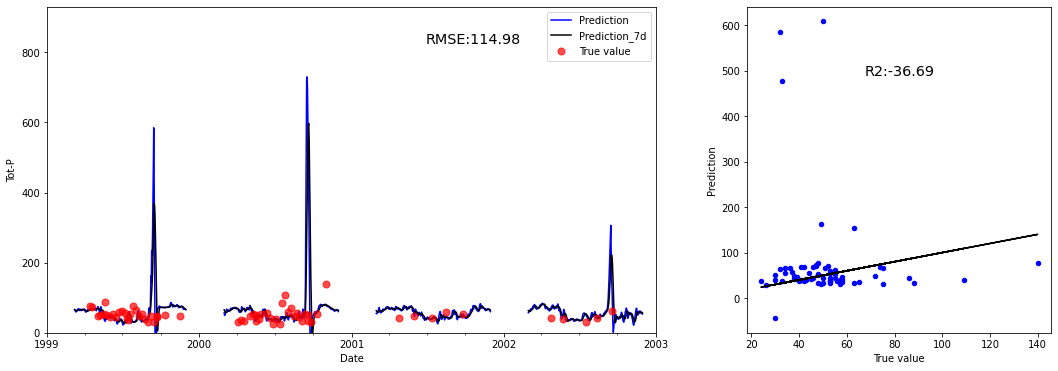

In [23]:
# predict nutreint 3
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 
Scaler = MinMaxScaler()
features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [24]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,U,AirT,Prec,RelHum,swr,CC,MLD,W,delT,Ice_d,day_from_iceoff,NOX-N,PO4-P,Tot-P
0,1990-03-01,-17.8,2.786438,-0.5350,0.09,87.250,51.505,0.79750,-18.0,0.002966,-0.008688,2.0,31.0,513.228516,23.497503,69.569344
1,1990-03-02,-17.8,7.849426,-0.6850,0.00,63.250,90.508,0.43250,-18.0,0.001339,-0.007953,2.0,32.0,513.228516,23.497503,69.569344
2,1990-03-03,-17.8,5.792219,-1.2975,0.03,56.125,93.743,0.40625,-18.0,0.000642,-0.007273,2.0,33.0,513.228516,23.497503,69.569344
3,1990-03-04,-17.8,5.742836,3.0775,5.24,84.875,52.951,0.75250,-18.0,0.000000,-0.003960,2.0,34.0,513.228516,23.497503,69.569344
4,1990-03-05,-17.8,12.217071,4.0650,0.83,68.750,62.892,0.70000,-18.0,0.000241,0.000475,2.0,35.0,513.228516,23.497503,69.569344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3570,2002-11-26,-17.8,3.396197,2.6775,9.75,98.750,8.086,0.97500,-18.0,0.001569,0.001628,81.0,266.0,263.020264,20.783012,57.067207
3571,2002-11-27,-17.8,4.465640,0.4650,0.25,96.875,25.670,0.59250,-18.0,0.001906,-0.000252,81.0,267.0,265.208527,20.870447,56.127789
3572,2002-11-28,-17.8,2.230251,-0.7850,0.30,97.250,8.143,0.91625,-18.0,0.008146,-0.003505,81.0,268.0,265.292114,18.209164,55.067493
3573,2002-11-29,-17.8,7.872476,-0.9725,0.63,89.000,6.721,0.99000,-18.0,0.000736,-0.000708,81.0,269.0,266.988586,17.097502,54.123363


Nutrient: NH4-N
['thermD', 'U', 'AirT', 'Prec', 'RelHum', 'swr', 'CC', 'MLD', 'W', 'delT', 'Ice_d', 'day_from_iceoff', 'NOX-N', 'PO4-P', 'Tot-P']
Delete features? (Y/N)N
Add features? (Y/N)N
(2475, 8, 15) (2475,) (1093, 8, 15) (1093,)
number of input timesteps: 8
number of features: 15
number of samples: 57
Test RMSE: 22.25
Test R2: 0.13
Training dataset RMSE 18.18 (+/- 5.92)
Training dataset R2 0.25 (+/- 0.24)
Model takes 2 min to run


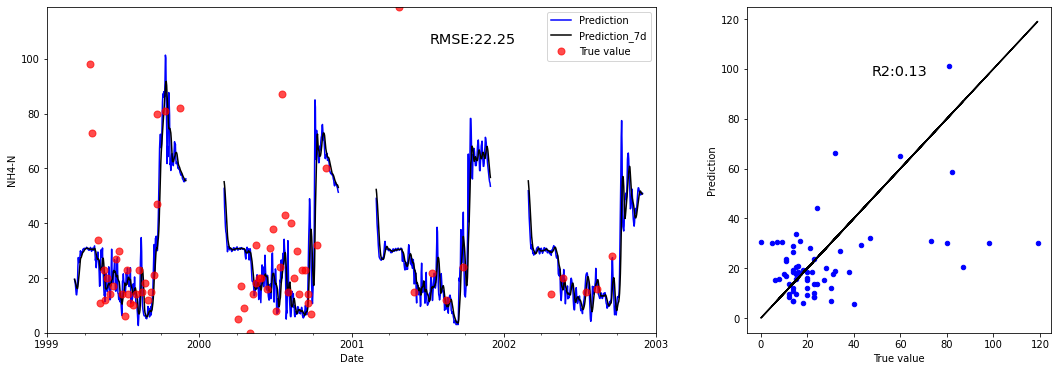

In [25]:
# predict nutreint 4
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 
Scaler = MinMaxScaler()
features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [26]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,U,AirT,Prec,RelHum,swr,CC,MLD,W,delT,Ice_d,day_from_iceoff,NOX-N,PO4-P,Tot-P,NH4-N
0,1990-03-01,-17.8,2.786438,-0.5350,0.09,87.250,51.505,0.79750,-18.0,0.002966,-0.008688,2.0,31.0,513.228516,23.497503,69.569344,26.629198
1,1990-03-02,-17.8,7.849426,-0.6850,0.00,63.250,90.508,0.43250,-18.0,0.001339,-0.007953,2.0,32.0,513.228516,23.497503,69.569344,26.629198
2,1990-03-03,-17.8,5.792219,-1.2975,0.03,56.125,93.743,0.40625,-18.0,0.000642,-0.007273,2.0,33.0,513.228516,23.497503,69.569344,26.629198
3,1990-03-04,-17.8,5.742836,3.0775,5.24,84.875,52.951,0.75250,-18.0,0.000000,-0.003960,2.0,34.0,513.228516,23.497503,69.569344,26.629198
4,1990-03-05,-17.8,12.217071,4.0650,0.83,68.750,62.892,0.70000,-18.0,0.000241,0.000475,2.0,35.0,513.228516,23.497503,69.569344,26.629198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3570,2002-11-26,-17.8,3.396197,2.6775,9.75,98.750,8.086,0.97500,-18.0,0.001569,0.001628,81.0,266.0,263.020264,20.783012,57.067207,50.508575
3571,2002-11-27,-17.8,4.465640,0.4650,0.25,96.875,25.670,0.59250,-18.0,0.001906,-0.000252,81.0,267.0,265.208527,20.870447,56.127789,50.465485
3572,2002-11-28,-17.8,2.230251,-0.7850,0.30,97.250,8.143,0.91625,-18.0,0.008146,-0.003505,81.0,268.0,265.292114,18.209164,55.067493,50.633175
3573,2002-11-29,-17.8,7.872476,-0.9725,0.63,89.000,6.721,0.99000,-18.0,0.000736,-0.000708,81.0,269.0,266.988586,17.097502,54.123363,50.898655


Nutrient: Si
['thermD', 'U', 'AirT', 'Prec', 'RelHum', 'swr', 'CC', 'MLD', 'W', 'delT', 'Ice_d', 'day_from_iceoff', 'NOX-N', 'PO4-P', 'Tot-P', 'NH4-N']
Delete features? (Y/N)N
Add features? (Y/N)N
(2475, 8, 16) (2475,) (1093, 8, 16) (1093,)
number of input timesteps: 8
number of features: 16
number of samples: 45
Test RMSE: 0.68
Test R2: 0.64
Training dataset RMSE 0.60 (+/- 0.14)
Training dataset R2 0.51 (+/- 0.18)
Model takes 1 min to run


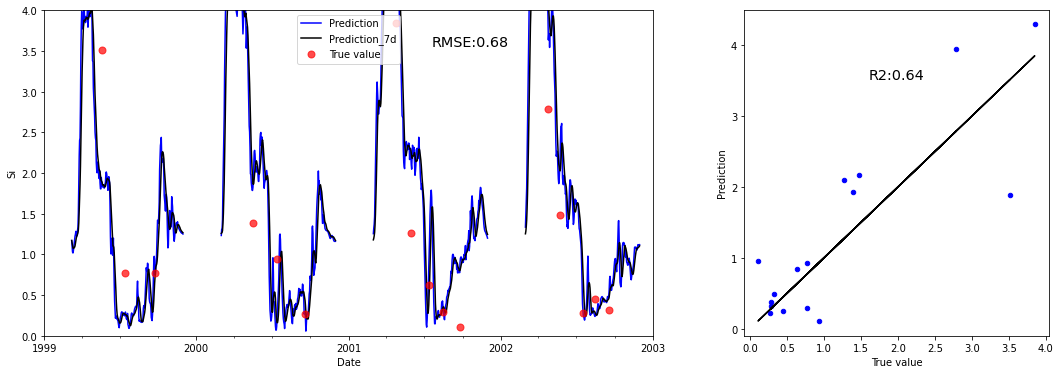

In [27]:
# predict nutreint 5
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

Scaler = MinMaxScaler()
features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [28]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,U,AirT,Prec,RelHum,swr,CC,MLD,W,delT,Ice_d,day_from_iceoff,NOX-N,PO4-P,Tot-P,NH4-N,Si
0,1990-03-01,-17.8,2.786438,-0.5350,0.09,87.250,51.505,0.79750,-18.0,0.002966,-0.008688,2.0,31.0,513.228516,23.497503,69.569344,26.629198,4.159938
1,1990-03-02,-17.8,7.849426,-0.6850,0.00,63.250,90.508,0.43250,-18.0,0.001339,-0.007953,2.0,32.0,513.228516,23.497503,69.569344,26.629198,4.159938
2,1990-03-03,-17.8,5.792219,-1.2975,0.03,56.125,93.743,0.40625,-18.0,0.000642,-0.007273,2.0,33.0,513.228516,23.497503,69.569344,26.629198,4.159938
3,1990-03-04,-17.8,5.742836,3.0775,5.24,84.875,52.951,0.75250,-18.0,0.000000,-0.003960,2.0,34.0,513.228516,23.497503,69.569344,26.629198,4.159938
4,1990-03-05,-17.8,12.217071,4.0650,0.83,68.750,62.892,0.70000,-18.0,0.000241,0.000475,2.0,35.0,513.228516,23.497503,69.569344,26.629198,4.159938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3570,2002-11-26,-17.8,3.396197,2.6775,9.75,98.750,8.086,0.97500,-18.0,0.001569,0.001628,81.0,266.0,263.020264,20.783012,57.067207,50.508575,1.121136
3571,2002-11-27,-17.8,4.465640,0.4650,0.25,96.875,25.670,0.59250,-18.0,0.001906,-0.000252,81.0,267.0,265.208527,20.870447,56.127789,50.465485,1.119802
3572,2002-11-28,-17.8,2.230251,-0.7850,0.30,97.250,8.143,0.91625,-18.0,0.008146,-0.003505,81.0,268.0,265.292114,18.209164,55.067493,50.633175,1.115119
3573,2002-11-29,-17.8,7.872476,-0.9725,0.63,89.000,6.721,0.99000,-18.0,0.000736,-0.000708,81.0,269.0,266.988586,17.097502,54.123363,50.898655,1.117429


Nutrient: CAR_dic
['U', 'delT', 'AirT', 'Prec', 'swr', 'MLD', 'W', 'Ice_d', 'days_from_iceoff', 'inflow', 'outflow', 'N_Nit', 'O2', 'N_Amm', 'Si']
Delete features? (Y/N)Y
['U', 'delT', 'AirT', 'Prec', 'swr', 'MLD', 'W', 'Ice_d', 'days_from_iceoff', 'inflow', 'outflow', 'N_Nit', 'O2', 'N_Amm', 'Si']
Location of the feature:-1
Delete features? (Y/N)N
Add features? (Y/N)N
(8800, 8, 14) (8800,) (1368, 8, 14) (1368,)
number of input timesteps: 8
number of features: 14
number of samples: 70
Test RMSE: 486.32
Test R2: 0.21
Training dataset RMSE 513.74 (+/- 278.03)
Training dataset R2 -0.34 (+/- 0.53)
Model takes 2 min to run


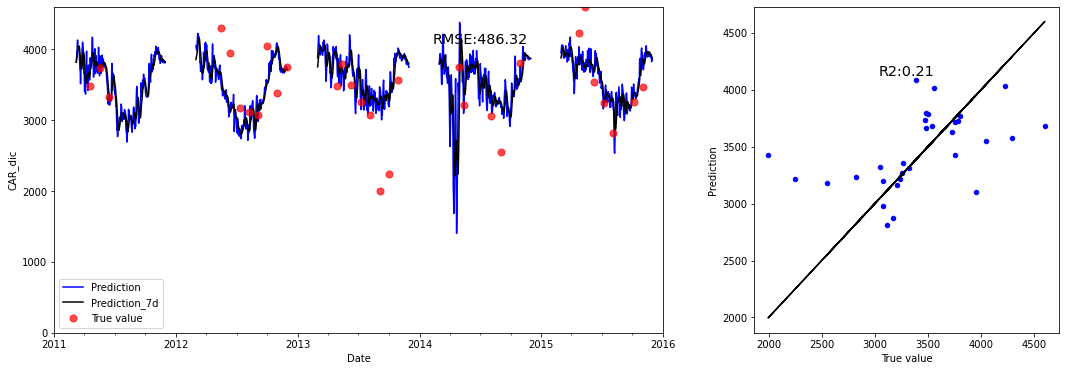

In [32]:
# predict nutreint 6
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

Scaler = MinMaxScaler()
features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [33]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,U,delT,AirT,Prec,swr,MLD,W,Ice_d,days_from_iceoff,inflow,outflow,N_Nit,O2,PO4,N_Amm,Si,CAR_dic
0,1979-03-01,1.593941,-2.620929,-2.992495,0.4762,185.210999,1.548121,0.000000,93.000000,-46,7.635921,7.867276,23.140509,419.221161,2.290661,15.315602,31.818928,4055.901611
1,1979-03-02,4.249354,-2.468256,-5.280408,0.6036,188.470290,1.501116,0.000000,93.000000,-45,7.287510,7.936561,23.140509,419.221161,2.290661,15.315602,31.818928,4055.901611
2,1979-03-03,3.202813,-2.664457,-1.517493,9.6772,75.183791,0.650000,0.000000,93.000000,-44,8.554949,8.209879,23.140509,419.221161,2.290661,15.315602,31.818928,4055.901611
3,1979-03-04,1.919469,-3.218732,0.616671,3.0956,109.187751,0.650000,0.000000,93.000000,-43,9.942403,8.346746,23.140509,419.221161,2.290661,15.315602,31.818928,4055.901611
4,1979-03-05,2.815478,-3.311187,-2.330826,0.0822,84.293958,0.650000,0.000000,93.000000,-42,9.816358,8.669169,23.140509,419.221161,2.290661,15.315602,31.818928,4055.901611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,2015-11-26,3.169159,0.778029,4.285010,25.0532,25.239375,25.000000,0.000000,100.958333,223,16.804982,11.418577,12.972775,331.407593,3.879638,21.239792,11.181655,3921.009521
10171,2015-11-27,5.685337,0.000000,2.327086,12.5068,66.596083,25.000000,0.000000,100.958333,224,15.235910,13.823858,13.713991,329.175903,4.222454,21.393560,18.336302,3882.438232
10172,2015-11-28,2.800493,1.181410,-0.982494,0.0000,81.125292,23.150000,1.769155,100.958333,225,17.910961,14.750084,13.798551,329.638031,4.322449,21.351166,44.339912,3823.813721
10173,2015-11-29,1.984414,1.383737,-1.319994,0.0000,42.381708,21.874141,2.731964,100.958333,226,18.948644,15.256056,14.820484,332.266510,4.282979,21.511284,35.685017,3865.531982


Nutrient: TOC
['AirP', 'AirT', 'RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2', 'NO3N', 'NH4N', 'PO4P', 'TOTP', 'TOTN']
Delete features? (Y/N)N
Add features? (Y/N)N
(4950, 8, 21) (4950,) (1093, 8, 21) (1093,)
number of input timesteps: 8
number of features: 21
number of samples: 99
Test RMSE: 0.86
Test R2: -0.42
Training dataset RMSE 0.71 (+/- 0.25)
Training dataset R2 0.08 (+/- 0.15)
Model takes 2 min to run


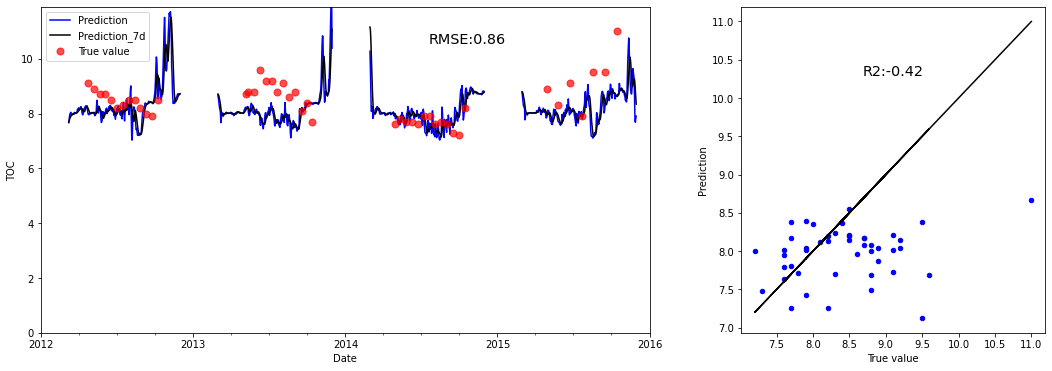

In [32]:
# predict nutreint 7
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 
Scaler=MinMaxScaler()
features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [33]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,AirP,AirT,RelHum,SWR,CC,Prec,U,delT,inflow(m3/s),outflow(m3/s),Ice_d,days from iceoff,W,MLD,thermD,O2,NO3N,NH4N,PO4P,TOTP,TOTN,TOC
0,1994-03-01,1018.4190,-9.955431,70.289411,55.50429,0.458692,0.830272,3.483176,0.256206,1.334310,0.618518,149,-54.0,2.724398,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702
1,1994-03-02,1012.0800,-8.835930,81.223724,54.56624,0.854867,1.530000,3.226721,0.256183,1.319589,0.606296,149,-53.0,2.191399,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702
2,1994-03-03,1002.8600,-4.911451,88.727730,107.72920,0.993754,0.423039,1.846146,0.256237,1.305278,0.594445,149,-52.0,4.483183,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702
3,1994-03-04,1005.3750,-2.776745,91.194580,134.25160,0.708459,0.000784,0.842008,0.256201,1.289619,0.582592,149,-51.0,254.546565,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702
4,1994-03-05,997.0792,2.236131,92.617668,80.39046,1.000008,0.338688,7.107113,0.256180,5.335259,2.310000,149,-50.0,0.000000,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6045,2015-11-26,994.5456,0.139770,93.686831,20.64251,0.548573,0.000000,2.173018,2.130598,13.161086,5.502222,81,258.0,20.616081,10.6501,10.6501,8.872602,55.972729,15.604255,8.623958,31.749716,784.934448,8.587276
6046,2015-11-27,985.3168,9.021081,90.547242,21.62850,0.968004,0.001345,6.680271,1.606879,12.064328,4.874074,81,259.0,3.705116,11.0968,11.0968,8.792369,16.538393,19.361982,7.025309,29.891218,702.546997,7.742613
6047,2015-11-28,978.9278,4.759586,86.624472,21.59980,0.634158,0.003703,4.535557,0.004524,21.783314,5.718518,81,260.0,0.032103,19.0000,19.0000,8.806619,158.694748,22.888605,6.790660,29.994944,729.221436,7.682547
6048,2015-11-29,969.5997,3.935289,87.554448,20.77313,0.928686,0.000335,4.846388,0.003058,29.578538,7.736296,81,261.0,0.049188,19.0000,19.0000,8.846630,190.166748,22.555815,6.788723,28.392122,764.089233,7.832428


Nutrient: SiO2
['AirP', 'AirT', 'RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2', 'NO3N', 'NH4N', 'PO4P', 'TOTP', 'TOTN', 'TOC']
Delete features? (Y/N)N
Add features? (Y/N)N
(4950, 8, 22) (4950,) (1093, 8, 22) (1093,)
number of input timesteps: 8
number of features: 22
number of samples: 167
Test RMSE: 1.15
Test R2: 0.43
Training dataset RMSE 0.83 (+/- 0.18)
Training dataset R2 0.51 (+/- 0.15)
Model takes 4 min to run


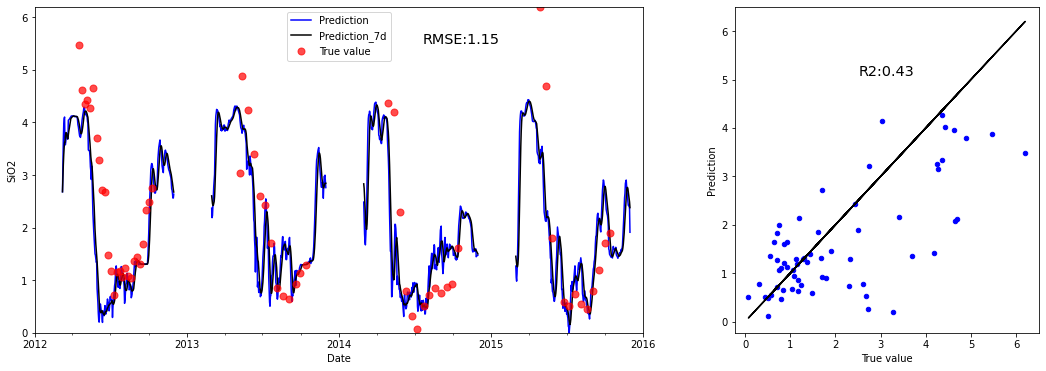

In [34]:
# predict nutreint 8
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [35]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,AirP,AirT,RelHum,SWR,CC,Prec,U,delT,inflow(m3/s),outflow(m3/s),Ice_d,days from iceoff,W,MLD,thermD,O2,NO3N,NH4N,PO4P,TOTP,TOTN,TOC,SiO2
0,1994-03-01,1018.4190,-9.955431,70.289411,55.50429,0.458692,0.830272,3.483176,0.256206,1.334310,0.618518,149,-54.0,2.724398,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
1,1994-03-02,1012.0800,-8.835930,81.223724,54.56624,0.854867,1.530000,3.226721,0.256183,1.319589,0.606296,149,-53.0,2.191399,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
2,1994-03-03,1002.8600,-4.911451,88.727730,107.72920,0.993754,0.423039,1.846146,0.256237,1.305278,0.594445,149,-52.0,4.483183,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
3,1994-03-04,1005.3750,-2.776745,91.194580,134.25160,0.708459,0.000784,0.842008,0.256201,1.289619,0.582592,149,-51.0,254.546565,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
4,1994-03-05,997.0792,2.236131,92.617668,80.39046,1.000008,0.338688,7.107113,0.256180,5.335259,2.310000,149,-50.0,0.000000,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6045,2015-11-26,994.5456,0.139770,93.686831,20.64251,0.548573,0.000000,2.173018,2.130598,13.161086,5.502222,81,258.0,20.616081,10.6501,10.6501,8.872602,55.972729,15.604255,8.623958,31.749716,784.934448,8.587276,2.421144
6046,2015-11-27,985.3168,9.021081,90.547242,21.62850,0.968004,0.001345,6.680271,1.606879,12.064328,4.874074,81,259.0,3.705116,11.0968,11.0968,8.792369,16.538393,19.361982,7.025309,29.891218,702.546997,7.742613,2.417079
6047,2015-11-28,978.9278,4.759586,86.624472,21.59980,0.634158,0.003703,4.535557,0.004524,21.783314,5.718518,81,260.0,0.032103,19.0000,19.0000,8.806619,158.694748,22.888605,6.790660,29.994944,729.221436,7.682547,2.430667
6048,2015-11-29,969.5997,3.935289,87.554448,20.77313,0.928686,0.000335,4.846388,0.003058,29.578538,7.736296,81,261.0,0.049188,19.0000,19.0000,8.846630,190.166748,22.555815,6.788723,28.392122,764.089233,7.832428,2.352034


Nutrient: Chl
['thermD', 'U', 'AirT', 'Prec', 'RelHum', 'swr', 'CC', 'MLD', 'W', 'delT', 'Ice_d', 'day_from_iceoff', 'NOX-N', 'PO4-P', 'Tot-P', 'NH4-N', 'Si']
Delete features? (Y/N)N
Add features? (Y/N)N
(2475, 8, 17) (2475,) (1093, 8, 17) (1093,)
number of input timesteps: 8
number of features: 17
number of samples: 56
Test RMSE: 15.35
Test R2: -1.72
Training dataset RMSE 11.86 (+/- 2.57)
Training dataset R2 -0.01 (+/- 0.34)
Model takes 2 min to run


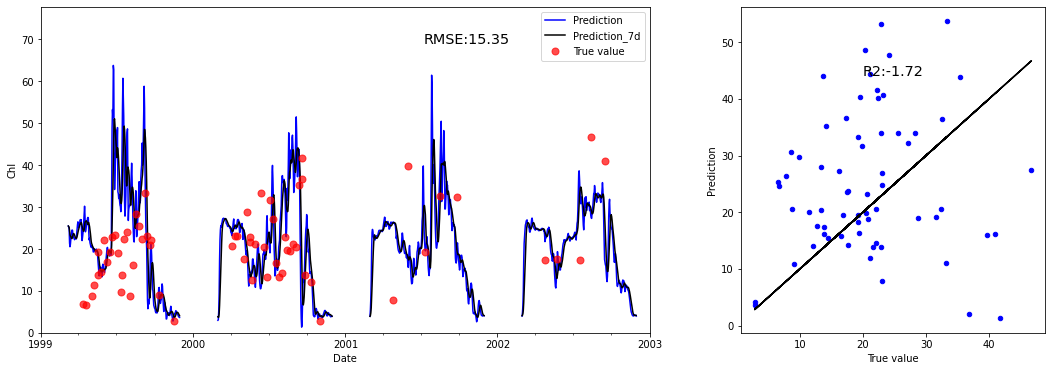

In [29]:
# predict Chl
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 
    
Scaler = MinMaxScaler()#PowerTransformer(standardize=False)
features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [30]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,U,AirT,Prec,RelHum,swr,CC,MLD,W,delT,Ice_d,day_from_iceoff,NOX-N,PO4-P,Tot-P,NH4-N,Si,Chl
0,1990-03-01,-17.8,2.786438,-0.5350,0.09,87.250,51.505,0.79750,-18.0,0.002966,-0.008688,2.0,31.0,513.228516,23.497503,69.569344,26.629198,4.159938,22.324915
1,1990-03-02,-17.8,7.849426,-0.6850,0.00,63.250,90.508,0.43250,-18.0,0.001339,-0.007953,2.0,32.0,513.228516,23.497503,69.569344,26.629198,4.159938,22.324915
2,1990-03-03,-17.8,5.792219,-1.2975,0.03,56.125,93.743,0.40625,-18.0,0.000642,-0.007273,2.0,33.0,513.228516,23.497503,69.569344,26.629198,4.159938,22.324915
3,1990-03-04,-17.8,5.742836,3.0775,5.24,84.875,52.951,0.75250,-18.0,0.000000,-0.003960,2.0,34.0,513.228516,23.497503,69.569344,26.629198,4.159938,22.324915
4,1990-03-05,-17.8,12.217071,4.0650,0.83,68.750,62.892,0.70000,-18.0,0.000241,0.000475,2.0,35.0,513.228516,23.497503,69.569344,26.629198,4.159938,22.324915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3570,2002-11-26,-17.8,3.396197,2.6775,9.75,98.750,8.086,0.97500,-18.0,0.001569,0.001628,81.0,266.0,263.020264,20.783012,57.067207,50.508575,1.121136,4.312150
3571,2002-11-27,-17.8,4.465640,0.4650,0.25,96.875,25.670,0.59250,-18.0,0.001906,-0.000252,81.0,267.0,265.208527,20.870447,56.127789,50.465485,1.119802,4.199388
3572,2002-11-28,-17.8,2.230251,-0.7850,0.30,97.250,8.143,0.91625,-18.0,0.008146,-0.003505,81.0,268.0,265.292114,18.209164,55.067493,50.633175,1.115119,4.212272
3573,2002-11-29,-17.8,7.872476,-0.9725,0.63,89.000,6.721,0.99000,-18.0,0.000736,-0.000708,81.0,269.0,266.988586,17.097502,54.123363,50.898655,1.117429,4.133369


In [32]:
Nut_memory.to_csv(lakename+'_LSTM predicted nutrient and Chl data.csv',sep='\t',index = False)